# Fish detection

In this assignment, we will locate and classify fish in images. We will use Deep Learning object detection to do the job. First, we will import all necessary modules that we need to get the job done. The next parts of the code are organized in: data analysis, data preprocessing, model training, and model validation. 

In [1]:
# Imports
%load_ext tensorboard
import tensorflow as tf
import datetime
import os # Module to access Operating System
import cv2 # Module for coputer vision
import keras # Module for deep learning
!pip -q install keras-cv > /dev/null
import keras_cv # Keras module for object detection
os.environ["KERAS_BACKEND"] = "torch"  # @param ["tensorflow", "jax", "torch"]
from keras_cv import bounding_box
from keras_cv import visualization
import tensorflow as tf

The system cannot find the path specified.


## Data analysis

In a first step we will load all our data. The data will be stored in a folder 'fish_data_detection' with subfolders 'images' and 'labels'. The images contain all images in the dataset, and the labels contain all corresponding labels in YOLO format. This format requires a .txt file for every image with a row for every object in the image that contains the class label (an integer) and the bounding box label (in the format [x, y, witdh height] of the bounding box).

In [2]:
# Class mapping
class_ids =  ['ANF', 'BIB', 'GUR', 'GUU', 'HAD', 'MEG', 'PLE', 'SOL', 'WHG', 'WIT']
class_mapping = dict(zip(range(len(class_ids)), class_ids))
 
# Path to images and annotations
path_images = "../../data/fish_data_detection/images/"
path_annot = "../../data/fish_data_detection/labels/"

# Print results
print(f'The dataset contains {len(os.listdir(path_images))} samples.')
print(f'\nThe classes are mapped to integers following: {class_mapping}')

The dataset contains 1850 samples.

The classes are mapped to integers following: {0: 'ANF', 1: 'BIB', 2: 'GUR', 3: 'GUU', 4: 'HAD', 5: 'MEG', 6: 'PLE', 7: 'SOL', 8: 'WHG', 9: 'WIT'}


In the next step, we will iterate over every image and save the path to the image, the bounding box coordinates, and the class labels in separate lists. 

In [3]:
# Init lists
image_paths = []
bbox = []
classes = []

# Loop over all samples
for image_path in os.listdir(path_images):

    # Read image
    image = cv2.imread('../../data/fish_data_detection/images/' + image_path)
    h, w, c = image.shape

    # Load labels
    boxes = []
    class_ids = []
    with open(path_annot + image_path.replace('.jpg', '.txt'), 'r') as f:
        for line in f:
            tmp = [float(x) for x in line.strip().split()]
            boxes.append([tmp[1]*w, tmp[2]*h, tmp[3]*w, tmp[4]*h])
            class_ids.append(tmp[0])

    # Add to lists
    image_paths.append(path_images + image_path)
    bbox.append(boxes)
    classes.append(class_ids)

# Print results
print(f'The first image has the following bounding box data: {bbox[0]}')
print(f'\nThe first image has the following class label data: {classes[0]}, which means it it of the class ANF')

# Compress the data for easy training
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

# Convert the data to a dataset object suitable for Keras
data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

The first image has the following bounding box data: [[382.49999999999994, 662.5, 161.0, 211.0]]

The first image has the following class label data: [0.0], which means it it of the class ANF


Next, we will performa a train and validation split of the data. We will have 70% training data, and 30% validation data.

In [4]:
# Determine the number of validation samples
SPLIT_RATIO = 0.3
num_val = int(len(os.listdir(path_images)) * SPLIT_RATIO)
 
# Split the dataset into train (70%) and validation sets (30%)
val_data = data.take(num_val)
train_data = data.skip(num_val)

# Print results
print(f'The training set contains {len(train_data)} samples')
print(f'\nThe validation set contains {len(val_data)} samples')

The training set contains 1295 samples

The validation set contains 555 samples


Next, we will wrap a Dataloader around the dataset that makes it possible for the network to retrieve batches of the dataset in the proper format. The training loop of Keras requires the samples to be formatted in a dictionary with keys "images", and "bounding_boxes", where the latter has keys 'classes', and 'boxes'. We define a batch size of 8, which means that the network retrieves samples in batches of 8.

In [5]:
# Function that converts the data in Keras format
def load_dataset(image_path, classes, bbox):

    # Read the image and decode it to Keras format
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # Format the labels
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }

    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}
 
# Create a data loader for the training and validation set
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)

# Define the batch size
BATCH_SIZE = 8

# Construct a Ragged dataset that can be loaded in batches
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

# Shuffle training set
train_ds = train_ds.shuffle(BATCH_SIZE * 4)

For bebugging purposes, we can validate visually if everything is correct by visualizing a batch of the dataset. 

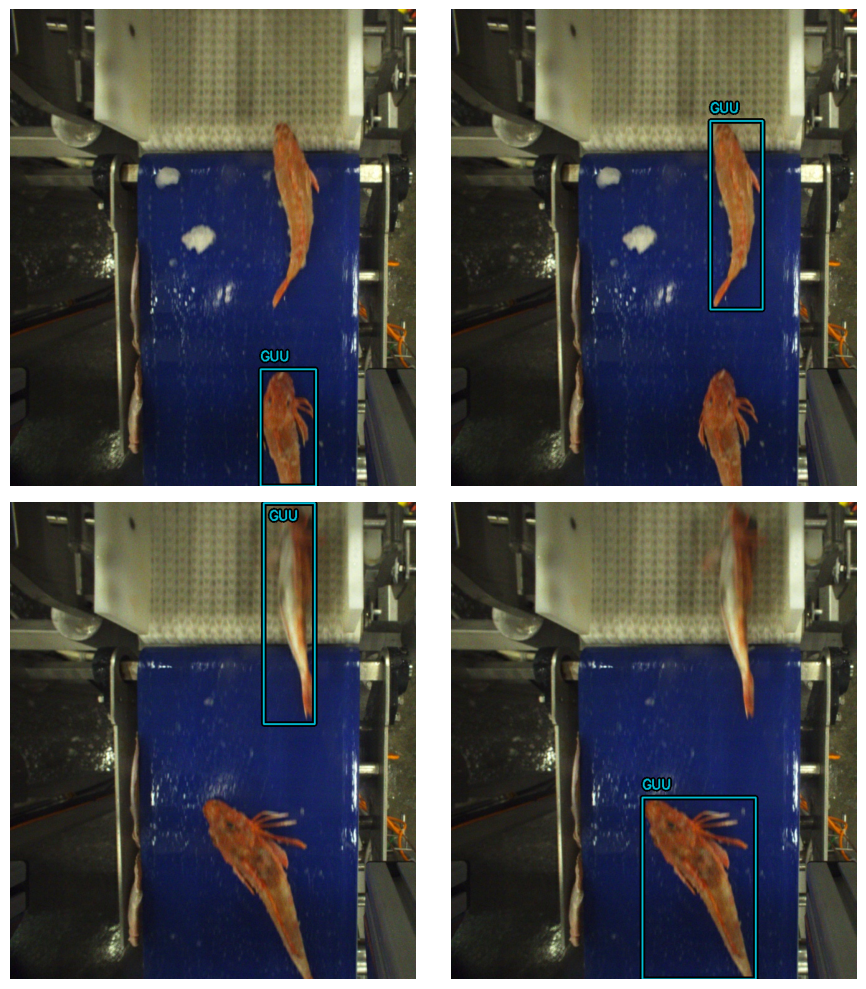

In [6]:
# Function to visualize dataste samples in a grid
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )
 
# Visualize one batch of the training set
visualize_dataset(train_ds, bounding_box_format="center_xywh", value_range=(0, 255), rows=2, cols=2)

We see that the labels are correctly placed in the images. A next step is data augementation which will apply several image transformations to our data in order to enhance the dataset and obtain a more robust model. We define some augmentation layers and apply them to the training set. For the validation set, we only perform resizing so that the image that gets fed to the network is in the proper size. 

In [7]:
# Define augmentation layers for training set
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="center_xywh"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(1.0, 1.0),
            bounding_box_format="center_xywh",
        ),
    ]
)

# Define resizing for validation set
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(1.0, 1.0),
    bounding_box_format="center_xywh",
)

# Define a mapping to ['images'] and '[bounding_boxes']
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(inputs["bounding_boxes"], max_boxes=32)

# Apply data augmentation to training set
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

# Apply resizing to validation set
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

For a full and efficient usage of the GPU and CPU, we apply the following methods to each Dataloader that take care of this. 

In [8]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Model training

In the following step, we will define a pretrained YOLOv8 model that we will train with our custom data. We use a pretrained backbone (the underlying architecture) and wrap this in a detector of which we can set the custom number of classes we want to detect. We compile the model with the proper optimizer, loss function for classification, and loss function for box regression. Lastly, we define some callbacks that will be called after every epoch, one that calculates COCO evaluation metrics, one that saves the best model, and one that logs data for visualization in Tensorboard.

In [10]:
# Create a model using a pretrained backbone
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_m_backbone_coco"  # We will use yolov8 medium backbone with coco weights
)

# Build a yolov8 model using the feature extractor backbone
model = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="center_xywh",
    backbone=backbone,
    fpn_depth=1,
)

# Set optimizer, loss function, and accuracy metrics
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, global_clipnorm=10.0),
    classification_loss="binary_crossentropy",
    box_loss="ciou",
)

# Define COCO metrics callback
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    val_ds, bounding_box_format="center_xywh"
)

# Define a callback that saves the best model
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    'model.weights.h5',
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=None,
)

# Define Tensorboard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

After compilation of the model, we can train it given our dataset. We will train for one epoch as training for more epochs takes a lot of time. We trained this network previously for 30 epochs and saved the model that we will load hereafter. 

In [11]:
# Start Tensorboard that will read the logs made by the model callback and visualize it in graphs.
%tensorboard --logdir logs/fit

In [12]:
# Train model
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    callbacks=[coco_metrics_callback, tensorboard_callback, model_checkpoint_callback],
)

  8/161 ━━━━━━━━━━━━━━━━━━━━ 14:41 6s/step - loss: 787.0958

KeyboardInterrupt: 

## Model validation

After model training, we will validate it. First, we load the trained model. We define a NonMax supressor that puts a threshold on the detection probabilities. Only detections with a probability higher than the threshold will be shown. Second, we visualize some detections on the validation set. 

In [ ]:
# Load best saved model
model.load_weights('best_model.weights.h5')

# Define Nonmax supressor
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="center_xywh",
    from_logits=True,
    iou_threshold=0.1,
    confidence_threshold=0.51,
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


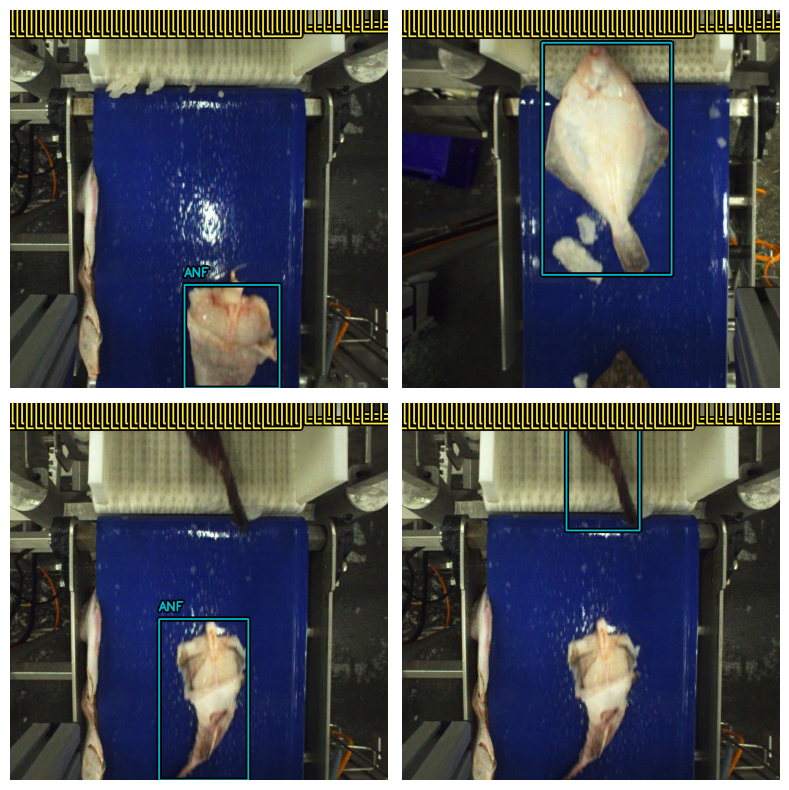

In [13]:
# Function to visualize detections
def visualize_detections(model, dataset, bounding_box_format):

    # Read one batch
    images, y_true = next(iter(dataset.take(1)))

    # Predict
    y_pred = model.predict(images)

    # Plot ground thruth and predictions
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

# Visualize detections
visualize_detections(model, dataset=val_ds, bounding_box_format="center_xywh")